In [6]:
import cv2
import os
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D


In [18]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()#train = 60.000, test = 10.000 Datensätze



10000

In [8]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)



In [4]:

model = tf.keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))# - Zahlen auf 0 setzen
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu')) # 128 Neuronen
model.add(tf.keras.layers.Dense(10, activation='softmax')) #alle zusammen = 1 jedes neuron hat eine Zahl zwischen 0 und 1. Probality of each digit

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])
model.fit(x_train, y_train, epochs= 9) # 9 Epochen, bei 10 Epochen war eine schelchtere Accuracy, bis 8 ist die Accuracy besser geworden und die Loss weniger
model.save('handwritten.model')



Epoch 1/9
1875/1875 [==============================] - 37s 19ms/step - loss: 0.1672 - accuracy: 0.9491
Epoch 2/9
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0602 - accuracy: 0.9811
Epoch 3/9
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0371 - accuracy: 0.9883
Epoch 4/9
 135/1875 [=>............................] - ETA: 29s - loss: 0.0203 - accuracy: 0.9947

KeyboardInterrupt: 

In [9]:
model = tf.keras.models.load_model('handwritten.model')
loss, accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0799 - accuracy: 0.9835


In [10]:
def predicthandwritten(path): 
 img = cv2.imread(path)[:,:,0]
 img = np.invert(np.array([img]))
 prediction = model.predict(img)
 print(prediction)
 plt.imshow(img[0])
 plt.show()
 print(np.argmax(prediction))
 



313/313 [==============================] - 2s 7ms/step
9


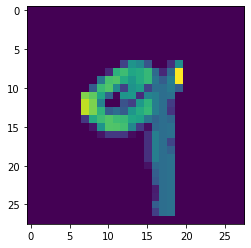

In [11]:
predictions = model.predict(x_test)
print(np.argmax(predictions[322]))
plt.imshow(x_test[322])
plt.show()


1/1 [==============================] - 0s 115ms/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


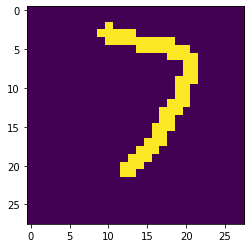

2


In [12]:
predicthandwritten("7.png")

Text(69.0, 0.5, 'Truth')

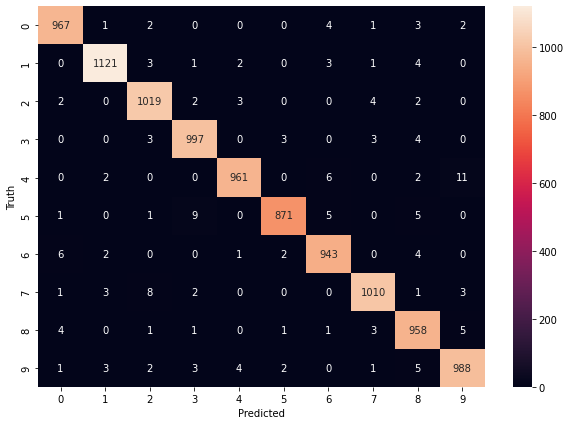

In [19]:
prediction_labels = [np.argmax(i) for i in predictions]

confusionmatrix = tf.math.confusion_matrix(labels=y_test, predictions=prediction_labels)

plt.figure(figsize = (10, 7))
sn.heatmap(confusionmatrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')